## Pneumonia detection on chest X-rays

Pneumonia is an inflammatory condition of the lung affecting primarily the small air sacs known as alveoli.Symptoms typically include some combination of productive or dry cough, chest pain, fever and difficulty breathing.
The severity of the condition is variable. Pneumonia is usually caused by infection with viruses or bacteria and less commonly by other microorganisms, certain medications or conditions such as autoimmune diseases.
Risk factors include cystic fibrosis, chronic obstructive pulmonary disease (COPD), asthma, diabetes, heart failure, a history of smoking, a poor ability to cough such as following a stroke and a weak immune system.
Diagnosis is often based on symptoms and physical examination.Chest X-ray, blood tests, and culture of the sputum may help confirm the diagnosis.
The disease may be classified by where it was acquired, such as community- or hospital-acquired or healthcare-associated pneumonia.

#### Importing the necessary libraries

In [1]:
import tensorflow as tf
import keras
from keras import Input
from keras.preprocessing.image import ImageDataGenerator, load_img
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D,BatchNormalization
from keras.layers import Activation, Dropout, Flatten, Dense
from keras import backend as K
from keras.optimizers import Adam,SGD,RMSprop
import os
from os import listdir, makedirs, getcwd, remove
import numpy as np
import pandas as pd
import glob2
import matplotlib.pyplot as plt
from keras.utils import to_categorical
from sklearn.preprocessing import LabelEncoder
import os
import scipy
import skimage
from skimage.transform import resize
import glob
import h5py
import shutil
import seaborn as sns
import cv2
import random as rn
from mlxtend.plotting import plot_confusion_matrix
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score
%matplotlib inline

C:\Users\Abhishek Gupta\anaconda3\lib\site-packages\tensorflow\python\framework\dtypes.py:516: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
C:\Users\Abhishek Gupta\anaconda3\lib\site-packages\tensorflow\python\framework\dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
C:\Users\Abhishek Gupta\anaconda3\lib\site-packages\tensorflow\python\framework\dtypes.py:518: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
C:\Users\Abhishek Gupta\anaconda3\lib\site-packages\tensorflow\python\framework

In [2]:
print(os.listdir('C:/Users/Abhishek Gupta/Desktop/X-ray dataset/17810_23812_bundle_archive (1)/chest_xray/chest_xray/train'))

['.DS_Store', 'NORMAL', 'PNEUMONIA']


The dataset is organized into 3 folders (train, test, val) and contains subfolders for each image category (Pneumonia/Normal). 
There are 5,863 X-Ray images (JPEG) and 2 categories (Pneumonia/Normal). 

#### preparing dataset

(1152, 1422, 3)
NORMAL


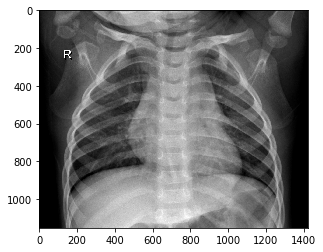

In [3]:
# here we have checked type of our images in our dataset.
#Since we are inputting 3 channels in our model so,images in our dataset must have 3 channels i.e.,RGB images.
img_name = 'IM-0117-0001.jpeg'
img_normal = load_img('C:/Users/Abhishek Gupta/Desktop/X-ray dataset/17810_23812_bundle_archive (1)/chest_xray/chest_xray/train/NORMAL/' + img_name)
img = cv2.imread('C:/Users/Abhishek Gupta/Desktop/X-ray dataset/17810_23812_bundle_archive (1)/chest_xray/chest_xray/train/NORMAL/' + img_name)
print(img.shape)
print('NORMAL')
plt.imshow(img_normal)
plt.show()


PNEUMONIA


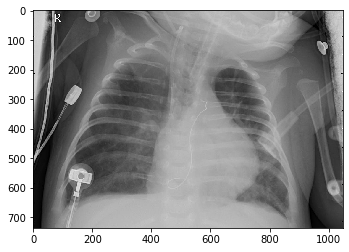

In [4]:
img_name = 'person63_bacteria_306.jpeg'
img_pneumonia = load_img('C:/Users/Abhishek Gupta/Desktop/X-ray dataset/17810_23812_bundle_archive (1)/chest_xray/chest_xray/train/PNEUMONIA/' + img_name)
print('PNEUMONIA')
plt.imshow(img_pneumonia)
plt.show()


In order to avoid overfitting problem, we need to expand artificially our dataset. We can make your existing dataset even larger. The idea is to alter the training data with small transformations to reproduce the variations. Approaches that alter the training data in ways that change the array representation while keeping the label the same are known as data augmentation techniques. Some popular augmentations people use are grayscales, horizontal flips, vertical flips, random crops, color jitters, translations, rotations, and much more. By applying just a couple of these transformations to our training data, we can easily double or triple the number of training examples and create a very robust model.

In [5]:
img_width, img_height = 120,120
train_dir = 'C:/Users/Abhishek Gupta/Desktop/X-ray dataset/17810_23812_bundle_archive (1)/chest_xray/train'
validation_dir ='C:/Users/Abhishek Gupta/Desktop/X-ray dataset/17810_23812_bundle_archive (1)/chest_xray/val'
test_dir = 'C:/Users/Abhishek Gupta/Desktop/X-ray dataset/17810_23812_bundle_archive (1)/chest_xray/test'

In [6]:
if K.image_data_format() == 'channels_first':
    input_shape = (3, img_width, img_height)
else:
    input_shape = (img_width, img_height,3)

#### Data augmentation and normalisation to avoide overfitting

In [11]:
batch_size=10
train_datagen = ImageDataGenerator(
    rescale=1. / 255,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True)

train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=(img_width, img_height),
    batch_size=batch_size,
    class_mode='binary')



Found 5216 images belonging to 2 classes.


In [8]:
test_datagen = ImageDataGenerator(rescale=1. / 255)
validation_generator = test_datagen.flow_from_directory(
    validation_dir,
    target_size=(img_width, img_height),
    batch_size=batch_size,
    class_mode='binary')

Found 16 images belonging to 2 classes.


In [9]:
test_generator = test_datagen.flow_from_directory(
    test_dir,
    target_size=(img_width, img_height),
    batch_size=batch_size,
    class_mode='binary')


Found 624 images belonging to 2 classes.


Since the target dataset is small, it is not a good idea to fine-tune the ConvNet due to the risk of overfitting. Since the target data is similar to the base data, we expect higher-level features in the ConvNet to be relevant to this dataset as well. Hence, we:

1. Remove the fully connected layers near the end of the pretrained base ConvNet
2. Add a new fully connected layer that matches the number of classes in the target dataset
3. Randomize the weights of the new fully connected layer and freeze all the weights from the pre-trained network
4. Train the network to update the weights of the new fully connected layers

#### Importing VGG-16 model as our pretrained model with imagenet weights

In [26]:
from keras.applications.vgg16 import VGG16
base_model=VGG16(include_top=False, weights='imagenet', input_shape=(120,120,3), pooling='avg')

#### Adding our own fully connected layers

In [27]:
model=Sequential()
model.add(base_model)
model.add(Dense(256,activation='relu'))
model.add(BatchNormalization())
model.add(Dense(1,activation='sigmoid'))


for layer in base_model.layers[:15]:
    layer.trainable=False
for layer in base_model.layers[15:]:
    layer.trainable=True

model.summary()
model.compile(optimizer=Adam(lr=1e-4),loss='binary_crossentropy',metrics=['accuracy'])


Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
vgg16 (Model)                (None, 512)               14714688  
_________________________________________________________________
dense_3 (Dense)              (None, 256)               131328    
_________________________________________________________________
batch_normalization_2 (Batch (None, 256)               1024      
_________________________________________________________________
dense_4 (Dense)              (None, 1)                 257       
Total params: 14,847,297
Trainable params: 7,211,521
Non-trainable params: 7,635,776
_________________________________________________________________


In [28]:
history=model.fit_generator(
    train_generator,
    steps_per_epoch=10,
    epochs=50,
    validation_data=validation_generator,validation_steps=10)

Epoch 1/50
10/10 [==============================] - 9s 938ms/step - loss: 0.5996 - accuracy: 0.7300 - val_loss: 0.6111 - val_accuracy: 0.8125
Epoch 2/50
10/10 [==============================] - 5s 527ms/step - loss: 0.3463 - accuracy: 0.8700 - val_loss: 0.5528 - val_accuracy: 0.8750
Epoch 3/50
10/10 [==============================] - 5s 527ms/step - loss: 0.4230 - accuracy: 0.8200 - val_loss: 0.5106 - val_accuracy: 0.8125
Epoch 4/50
10/10 [==============================] - 5s 513ms/step - loss: 0.4369 - accuracy: 0.8300 - val_loss: 0.5692 - val_accuracy: 0.6250
Epoch 5/50
10/10 [==============================] - 5s 526ms/step - loss: 0.4135 - accuracy: 0.8500 - val_loss: 0.5452 - val_accuracy: 0.6250
Epoch 6/50
10/10 [==============================] - 5s 535ms/step - loss: 0.3670 - accuracy: 0.9000 - val_loss: 0.4410 - val_accuracy: 0.5625
Epoch 7/50
10/10 [==============================] - 5s 528ms/step - loss: 0.3755 - accuracy: 0.8500 - val_loss: 0.5637 - val_accuracy: 0.5625
Epoch 

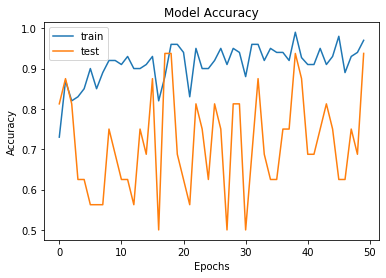

In [29]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epochs')
plt.legend(['train', 'test'])
plt.show()

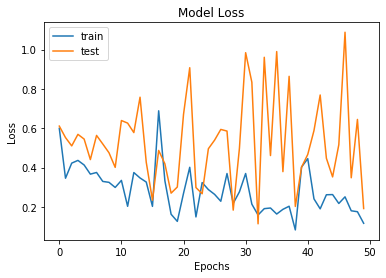

In [30]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epochs')
plt.legend(['train', 'test'])
plt.show()

#### model evaluation

In [31]:
scores = model.evaluate_generator(test_generator)
print("\n%s: %.2f%%" % (model.metrics_names[1], scores[1]*100))


accuracy: 89.26%


#### preparing test data for other scores and prediction

In [32]:
X=[]
Y=[]
normal_img_dir='C:/Users/Abhishek Gupta/Desktop/X-ray dataset/17810_23812_bundle_archive (1)/chest_xray/test/NORMAL'
infected_img_dir='C:/Users/Abhishek Gupta/Desktop/X-ray dataset/17810_23812_bundle_archive (1)/chest_xray/test/PNEUMONIA'


In [33]:
from tqdm import tqdm
IMG_SIZE= 120
def locate_label(img,img_typ):
    return img_typ

def test_data(img_typ,DIR):
    for img in tqdm(os.listdir(DIR)):
        label=locate_label(img,img_typ)
        path=os.path.join(DIR,img)
        img = cv2.imread(path,cv2.IMREAD_COLOR)
        img = cv2.resize(img, (IMG_SIZE,IMG_SIZE))
        
        X.append(np.array(img))
        Y.append((label))

In [34]:
test_data('0',normal_img_dir)
print(len(X))

100%|██████████| 234/234 [00:12<00:00, 18.20it/s]

234


In [35]:
test_data('1',infected_img_dir)
print(len(X))

100%|██████████| 390/390 [00:07<00:00, 50.47it/s]

624


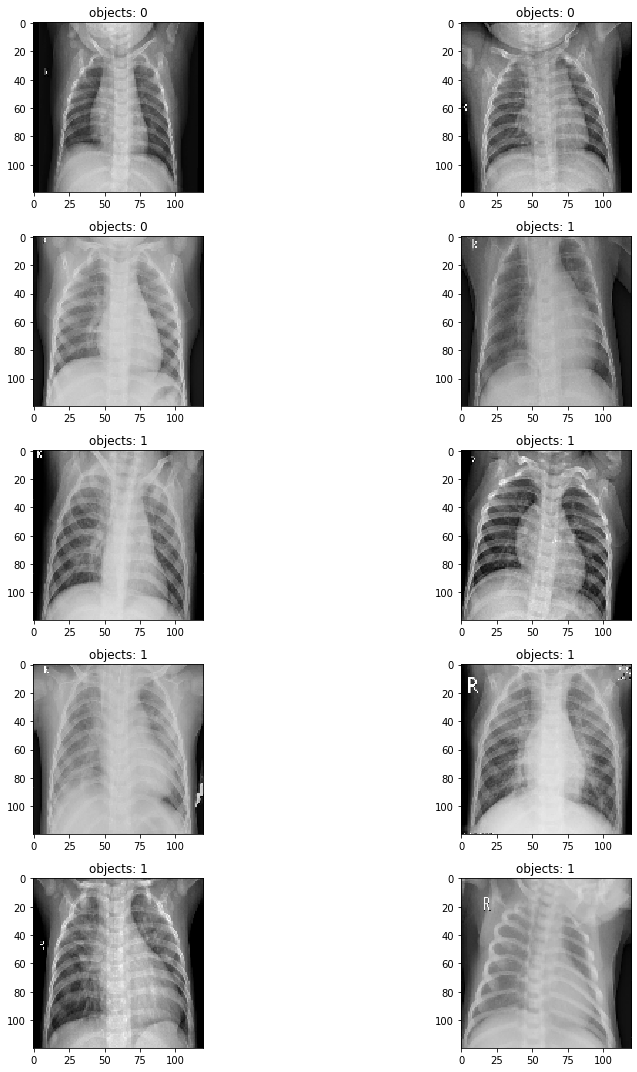

In [36]:
fig,ax=plt.subplots(5,2)
fig.set_size_inches(15,15)
for i in range(5):
    for j in range (2):
        l=rn.randint(0,len(Y))
        ax[i,j].imshow(X[l])
        ax[i,j].set_title('objects: '+Y[l])
        
plt.tight_layout()

In [37]:
e=LabelEncoder()
E=e.fit_transform(Y)
print(E)
E=E.reshape(624,1)
print(E)

[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 

In [38]:
le=LabelEncoder()
Z=le.fit_transform(Y)
Z=to_categorical(Z,2)
X=np.array(X)
X=X/255
print(Z)


[[1. 0.]
 [1. 0.]
 [1. 0.]
 ...
 [0. 1.]
 [0. 1.]
 [0. 1.]]


In [39]:
y_pred = model.predict_classes(X)

print(accuracy_score(np.argmax(Z, axis=1),y_pred))

0.8910256410256411


In [40]:
preds = model.predict_classes(X, batch_size=10)
print(preds)
preds=preds.reshape(624,)
#preds = np.argmax(preds, axis=0)

# Original labels
#orig_test_labels = np.argmax(Z, axis=-1)

#print(orig_test_labels.shape)
print(preds.shape)
#print(preds)

[[0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [1]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [1]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [1]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [1]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [1]
 [0]
 [0]
 [1]
 [0]
 [0]
 [1]
 [1]
 [1]
 [1]
 [1]
 [1]
 [0]
 [1]
 [0]
 [0]
 [1]
 [1]
 [1]
 [1]
 [1]
 [1]
 [1]
 [1]
 [0]
 [0]
 [0]
 [1]
 [0]
 [0]
 [1]
 [1]
 [1]
 [1]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [1]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]


<Figure size 432x288 with 0 Axes>

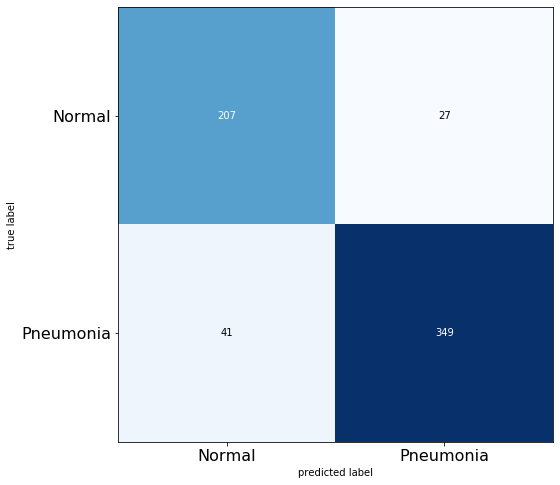

In [41]:
cm  = confusion_matrix(E, preds)
plt.figure()
plot_confusion_matrix(cm,figsize=(12,8), hide_ticks=True,cmap=plt.cm.Blues)
plt.xticks(range(2), ['Normal', 'Pneumonia'], fontsize=16)
plt.yticks(range(2), ['Normal', 'Pneumonia'], fontsize=16)
plt.show()

In [42]:
# Calculate Precision and Recall
tn, fp, fn, tp = cm.ravel()

precision = tp/(tp+fp)
recall = tp/(tp+fn)

print("Recall of the model is {:.2f}".format(recall))
print("Precision of the model is {:.2f}".format(precision))

Recall of the model is 0.89
Precision of the model is 0.93


In [43]:
from sklearn.metrics import classification_report,confusion_matrix
print(classification_report(E, preds, target_names = ['Pneumonia (Class 1)','Normal (Class 0)']))

                     precision    recall  f1-score   support

Pneumonia (Class 1)       0.83      0.88      0.86       234
   Normal (Class 0)       0.93      0.89      0.91       390

           accuracy                           0.89       624
          macro avg       0.88      0.89      0.89       624
       weighted avg       0.89      0.89      0.89       624



In [ ]:
del model
K.clear_session()